In [22]:
import numpy as np
import logging
import pandas as pd
import joblib
from pathlib import Path
from datetime import datetime
from scipy.stats import skew, kurtosis
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline

In [ ]:
NOTEBOOK_NAME = "BIGMIX-RF-Default"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path("../results") / f"{timestamp}_{NOTEBOOK_NAME}"
SUBDIRS = ["model", "optuna", "metrics", "logs"]

for sd in SUBDIRS:
    (RUN_DIR / sd).mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved under: {RUN_DIR.resolve()}")

def save_model(model, name="rf-runtime-model"):

    model_dir = RUN_DIR / "model"
    model_dir.mkdir(parents=True, exist_ok=True)

    if hasattr(model, "save_model"):
        model_path = model_dir / f"{name}.json"
        model.save_model(model_path)
    else:
        model_path = model_dir / f"{name}.pkl"
        joblib.dump(model, model_path)

    print(f"Model saved to {model_path.resolve()}")

logfile = RUN_DIR / "logs" / "run.log"
logging.basicConfig(filename=logfile, filemode="w",
                    level=logging.INFO,
                    format="%(asctime)s %(levelname)s | %(message)s")
logging.info("Run directory initialised")

In [24]:
df_features = pd.read_csv('data/BIGMIX-train_test-features-withfilename.csv')
df_cplex_runtimes = pd.read_csv('data/BIGMIX-cplex.csv', header=None, names=["INSTANCE_ID","runtime"])
df_cplex_runtimes["runtime"] = pd.to_numeric(df_cplex_runtimes["runtime"])
df_features.head()

,INSTANCE_ID,probtype,n_vars,n_constr,n_nzcnt,nq_vars,nq_constr,nq_nzcnt,lp_avg,lp_l2_avg,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,23305.0,12498.0,169861.0,0.0,0.0,0.0,0.003246,0.032012,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.51667
1,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,1693.0,1628.0,12084.0,0.0,0.0,0.0,0.029611,0.096698,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.38333
2,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,3815.0,2676.0,15667.0,0.0,0.0,0.0,0.088451,1.245560,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.38333
3,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,15864.0,6844.0,53808.0,0.0,0.0,0.0,0.000003,0.000162,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.56667
4,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,838.0,1337.0,3418.0,0.0,0.0,0.0,0.398217,0.413461,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.36667


In [25]:
df_cplex_runtimes.head()

,INSTANCE_ID,runtime
0,/ubc/cs/project/arrow/projects/MIP_data/coral-...,35.56
1,/ubc/cs/project/arrow/projects/MIP_data/coral-...,3600.01
2,/ubc/cs/project/arrow/projects/MIP_data/coral-...,105.12
3,/ubc/cs/project/arrow/projects/MIP_data/coral-...,4.78
4,/ubc/cs/project/arrow/projects/MIP_data/coral-...,46.91


In [26]:
# Steps from Hutter et al.(compare preeliminaries):
# 1. Remove constant columns
# 2. Replace the sentinel –512 with NaN
# 3. Standardise every remaining column to mean 0 / std 1. The means/SDs are computed ignoring NaNs.
# 4. Fill the remaining NaNs with 0, so a “missing” value is interpreted as “the mean of that column” after scaling.


# instance id does nothing for performance prediction
df_features.drop(['INSTANCE_ID'], inplace=True, axis=1)
df_cplex_runtimes.drop(['INSTANCE_ID'], inplace=True, axis=1)
# Some rows have the same values - we won't be needing them as they only increase complexity.
single_value_cols = df_features.columns[df_features.nunique(dropna=False) == 1]
single_value_cols

Index([' probtype', ' nq_vars', ' nq_constr', ' nq_nzcnt', ' num_s_variables',
       ' num_n_variables', ' ratio_s_variables', ' ratio_n_variables',
       ' itcnt_max', ' numnewsolution_sum', ' newin_sum', ' nodeleft_avg',
       ' nodeleft_varcoef', ' diffObj_avg', ' diffObj_median',
       ' diffObj_varcoef', ' diffObj_q90mq10', ' numfeas', ' iinf_avg',
       ' iinf_median', ' iinf_varcoef', ' iinf_q90mq10', ' diffBestInt_avg',
       ' diffBestInt_median', ' diffBestInt_varcoef', ' diffBestInt_q90mq10',
       ' diffBestObjUp_avg', ' diffBestObjUp_median', ' diffBestObjUp_varcoef',
       ' diffBestObjUp_q90mq10', ' numcuts_sum', ' diffGap_avg',
       ' diffGap_median', ' diffGap_varcoef', ' diffGap_q90mq10'],
      dtype='object')

In [27]:
df_features.drop(single_value_cols, axis=1, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [28]:
df_features.dtypes

n_vars             float64
n_constr           float64
n_nzcnt            float64
lp_avg             float64
lp_l2_avg          float64
                    ...   
time_relax         float64
time_VCG0          float64
time_VCG1          float64
time_VCG2          float64
cplex_prob_time    float64
Length: 113, dtype: object

In [29]:
df_features.replace(-512, np.nan, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [30]:
stats = pd.DataFrame({
    'mean':        df_features.mean(),
    'std':         df_features.std(),
    'range':       df_features.max() - df_features.min(),
    'IQR':         df_features.quantile(0.75) - df_features.quantile(0.25),
    'CV':          df_features.std() / df_features.mean().abs().replace(0, np.nan),
    'skewness':    df_features.apply(skew, nan_policy='omit'),
    'kurtosis':    df_features.apply(lambda x: kurtosis(x, nan_policy='omit')),
    'outlier_%':   df_features.apply(lambda x: ((x < x.mean() - 3*x.std()) | (x > x.mean() + 3*x.std())).mean() * 100)
})

# sorting by biggest disparities.
stats_sorted = stats.sort_values(by='std', ascending=False)
print(stats_sorted)

                                    mean           std         range  \
rhs_c_1_varcoef             8.232340e+12  1.201055e+14  2.198990e+15   
vcg_constr_weight0_varcoef  1.573769e+09  4.371219e+10  1.366271e+12   
rhs_c_0_varcoef             7.790292e+08  2.181342e+10  7.419560e+11   
lp_objval                   6.796390e+08  1.848195e+10  5.505064e+11   
vcg_var_weight1_varcoef     8.308102e+08  1.359669e+10  3.866540e+11   
...                                  ...           ...           ...   
ratio_i_variables           6.284712e-02  2.021037e-01  1.000000e+00   
time_VCG0                   4.835541e-02  1.710137e-01  3.016670e+00   
a_normalized_varcoefs1_avg  6.486363e-02  1.669082e-01  1.756240e+00   
ratio_unbounded_disc        2.790155e-02  1.644828e-01  1.000000e+00   
time_VCG1                   1.885211e-02  1.028872e-01  1.966670e+00   

                                     IQR         CV   skewness     kurtosis  \
rhs_c_1_varcoef                 4.560070  14.589477  16.

In [31]:
X = df_features.values
runtimes = df_cplex_runtimes['runtime'].clip(lower=0.005).values
y = np.log10(runtimes)

In [32]:
N_FOLDS   = 10
RANDOM_STATE    = 1234

BASELINE_PARAMS = dict(
    n_estimators       = 10,
    max_features       = 0.5,
    min_samples_split  = 5,
    bootstrap          = False,
    random_state       = RANDOM_STATE
)

In [33]:
class ZScoreFillNA(BaseEstimator, TransformerMixin):
    """
    Per-column z-scoring that ignores NaNs while computing μ, σ,
    then fills remaining NaNs with 0 (the post-scaling mean).
    API compatible with scikit-learn.
    """
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.means_ = np.nanmean(X, axis=0)
        self.stds_  = np.nanstd(X, axis=0)
        self.stds_[self.stds_ == 0] = 1.0      # avoid /0 for constants
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        Z = (X - self.means_) / self.stds_
        # Replace NaNs created either by original missing values
        # or by 0/0 operations.
        return np.where(np.isnan(Z), 0.0, Z)

In [34]:
class ExtraTreesWithUncertainty(BaseEstimator, RegressorMixin):
    """
    Extra-Trees + Hutter-et-al. uncertainty estimates.
    Call predict(X) --> mean
    Call predict(X, return_std=True) --> (mean, std)
    """
    def __init__(self, sigma_min=0.01, **et_params):
        self.sigma_min = sigma_min
        self.et_params = et_params    # stored so that get_params works later

    # ---------------------------------------------------------------------
    # scikit-learn API
    # ---------------------------------------------------------------------
    def fit(self, X, y):
        # 1) Fit a vanilla Extremely Randomised Trees ensemble
        self.model_ = ExtraTreesRegressor(**self.et_params)
        self.model_.fit(X, y)

        # 2) Pre-compute per-leaf mean & variance on the training data
        self._leaf_means_ = []
        self._leaf_vars_  = []
        for tree in self.model_.estimators_:
            leaf_id = tree.apply(X)                # leaf index for every sample
            unique_leaves = np.unique(leaf_id)
            means = np.zeros(tree.tree_.node_count)
            vars_  = np.zeros(tree.tree_.node_count)

            for leaf in unique_leaves:
                idx = leaf_id == leaf
                # mean and variance of y in this leaf
                mu  = float(np.mean(y[idx]))
                var = float(np.var(y[idx], ddof=0))
                vars_[leaf]  = max(var, self.sigma_min)
                means[leaf] = mu

            self._leaf_means_.append(means)
            self._leaf_vars_.append(vars_)
        return self

    def predict(self, X, return_std=False):
        """
        If return_std=False  -> np.ndarray, shape (n_samples,)
        If return_std=True   -> (mean, std)
        """
        mu_b, sig2_b = self._collect_tree_stats(X)   # shape (B, n_samples)

        mu = mu_b.mean(axis=0)

        if not return_std:
            return mu

        # law of total variance across the mixture of trees
        var_total = (sig2_b + mu_b**2).mean(axis=0) - mu**2
        return mu, np.sqrt(var_total)

    # ---------------------------------------------------------------------
    # utilities
    # ---------------------------------------------------------------------
    def _collect_tree_stats(self, X):
        """Return arrays of per-tree means and variances, shape (B, n_samples)."""
        mus   = []
        sig2s = []
        for tree, m_vec, v_vec in zip(self.model_.estimators_,
                                      self._leaf_means_,
                                      self._leaf_vars_):
            leaf = tree.apply(X)
            mus.append(m_vec[leaf])
            sig2s.append(v_vec[leaf])
        return np.vstack(mus), np.vstack(sig2s)

    # ---------------------------------------------------------------------
    # GridSearchCV / get_params
    # ---------------------------------------------------------------------
    def get_params(self, deep=True):
        return {"sigma_min": self.sigma_min, **self.et_params}

    def set_params(self, **params):
        self.sigma_min = params.pop("sigma_min", self.sigma_min)
        self.et_params.update(params)
        return self


In [35]:
# ------------------------------------------------------------
# Helpers for one vector of predictions
# ------------------------------------------------------------
def gaussian_log_likelihood(y_true, mu, sigma):
    """
    Mean log-likelihood under N(mu, sigma^2).
    Higher (closer to 0)  ⇒ better.
    """
    var = np.maximum(sigma**2, 1e-12)          # guard against zero
    ll  = -0.5 * np.log(2*np.pi*var) - 0.5*((y_true - mu)**2) / var
    return ll.mean()                           # same as Matlab’s ‘ll’

def corr_coeff(y_true, mu):
    """
    Pearson correlation between target and predicted mean.
    Equals Matlab’s ‘cc’.
    """
    return np.corrcoef(y_true, mu)[0, 1]

In [36]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [37]:
pipe = Pipeline([
    ('scale', ZScoreFillNA()),
    ('rf',    ExtraTreesWithUncertainty(sigma_min=0.01, **BASELINE_PARAMS))
])

rmses, lls, ccs = [], [], []
for train_idx, test_idx in cv.split(X):
    # fit one fold
    pipe.fit(X[train_idx], y[train_idx])
    mu, sigma = pipe.predict(X[test_idx], return_std=True)

    # --- metrics ---------------------------------------------------------
    rmses.append(np.sqrt(mean_squared_error(y[test_idx], mu)))
    lls.append(gaussian_log_likelihood(y[test_idx], mu, sigma))
    ccs.append(corr_coeff(y[test_idx], mu))

print(f"{N_FOLDS}-fold RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"{N_FOLDS}-fold  LL:  {np.mean(lls):.3f} ± {np.std(lls):.3f}")
print(f"{N_FOLDS}-fold  CC:  {np.mean(ccs):.3f} ± {np.std(ccs):.3f}")

10-fold RMSE: 0.6581 ± 0.0598
10-fold  LL:  -0.940 ± 0.704
10-fold  CC:  0.905 ± 0.019


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.base import clone


def plot_runtime_scatter_sklearn(pipe, X, y_log10,
                                 n_folds=10,
                                 lower=1e-4, upper=1e4,
                                 figsize=(6, 6),
                                 random_state=1234):
    """
    Cross‑validated true vs. predicted runtime plot (log–log).

    Parameters
    ----------
    pipe      : any *fitted or unfitted* scikit‑learn estimator/pipeline
    X         : ndarray or DataFrame, shape (n_samples, n_features)
    y_log10   : ndarray or Series,   shape (n_samples,)
                log10‑transformed runtimes.
    """

    kf         = KFold(n_splits=n_folds, shuffle=True,
                       random_state=random_state)
    y_pred_log = np.empty_like(y_log10, dtype=float)

    X_np = np.asarray(X)
    y_np = np.asarray(y_log10)

    # ------------------------------------------------------------
    # 1. cross‑validated predictions
    # ------------------------------------------------------------
    for train_idx, test_idx in kf.split(X_np):
        pipe_clone = clone(pipe)              # fresh copy for this fold
        pipe_clone.fit(X_np[train_idx], y_np[train_idx])
        y_pred_log[test_idx] = pipe_clone.predict(X_np[test_idx])

    # ------------------------------------------------------------
    # 2. convert to seconds for plotting
    # ------------------------------------------------------------
    y_true_sec = 10 ** y_np
    y_pred_sec = 10 ** y_pred_log

    inside  = (y_pred_sec >= lower) & (y_pred_sec <= upper)
    outside = ~inside

    # ------------------------------------------------------------
    # 3. plot
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(y_true_sec[inside],  y_pred_sec[inside],
               s=18, alpha=0.6, edgecolor="k")
    ax.scatter(y_true_sec[outside],
               np.clip(y_pred_sec[outside], lower, upper),
               s=18, alpha=0.6, edgecolor="k", marker="x", color="tab:blue")

    ax.plot([lower, upper], [lower, upper],
            linestyle="--", linewidth=1.0, color="red")

    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    tick_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    tick_lbls = [fr"$10^{{{int(np.log10(t))}}}$" for t in tick_vals]
    ax.set_xticks(tick_vals, tick_lbls)
    ax.set_yticks(tick_vals, tick_lbls)

    ax.set_xlabel("true runtime (s)")
    ax.set_ylabel("predicted runtime (s)")
    ax.set_title(f"Modern RF (No hyp.)")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    return fig, ax


/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_36410/2859385401.py:56: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(y_true_sec[outside],


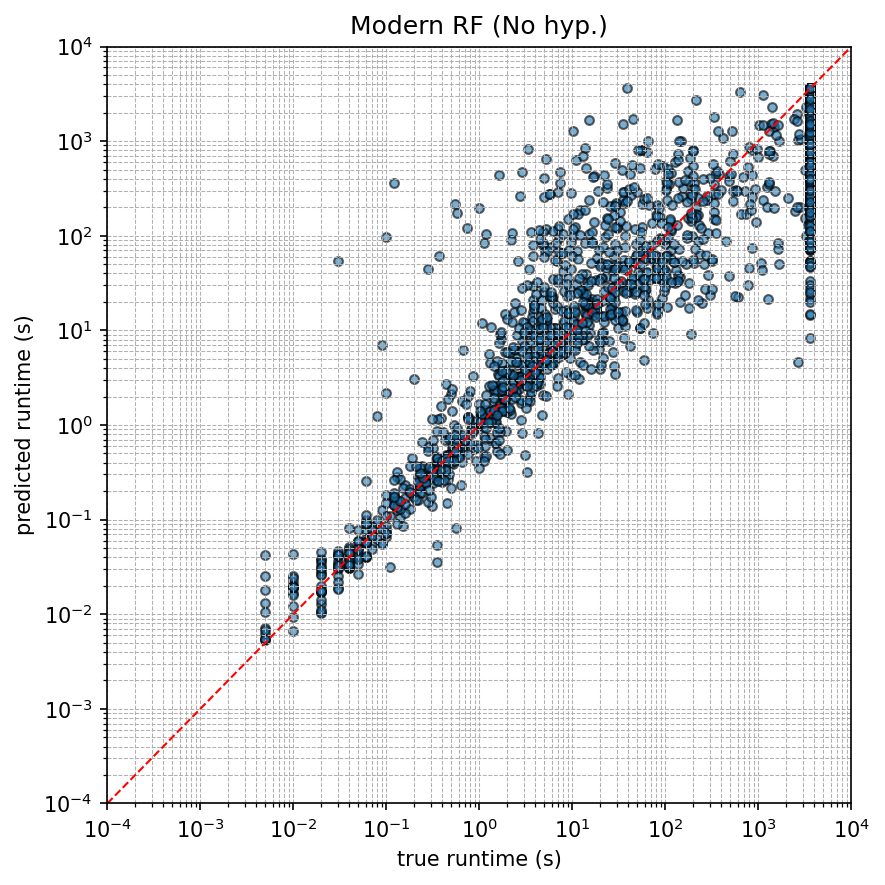

In [42]:
fig, ax = plot_runtime_scatter_sklearn(pipe, X, y, n_folds=10)
plt.show()

In [40]:
pipe.fit(X, y)
save_model(pipe, name="rf-runtime-pipeline-zscore")

,steps,"[('scale', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sigma_min,0.01
,n_estimators,10
,max_features,0.5
,min_samples_split,5
,bootstrap,False
,random_state,1234
